In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import statsmodels.api as sm
import scipy.stats as stats

from IPython.core import display


%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
fname = "nutrition.csv"
scatter_pt_size = 5

## Data Cleaning
Convert "Gender" data to male = 1 and female = 0.

In [2]:
#data = pd.read_csv(fname)
data = pd.read_csv(fname, usecols=['Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size', 'Gender'])
data = data.dropna()
data = data.rename(columns={'High_Confidence_Limit ': 'High_Confidence_Limit'})

print("size of the data: ", len(data))
data.head(10)

size of the data:  3814


,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Gender
1,32.3,29.9,34.7,2581.0,Male
2,31.8,30.0,33.6,4723.0,Female
29,39.0,36.5,41.6,2581.0,Male
30,30.5,28.7,32.4,4723.0,Female
63,40.1,38.2,42.1,4792.0,Female
77,47.9,45.2,50.6,2439.0,Male
85,26.6,24.2,29.0,2422.0,Male
86,22.3,20.6,24.1,4713.0,Female
114,45.4,42.7,48.1,2441.0,Male
115,39.6,37.6,41.6,4750.0,Female


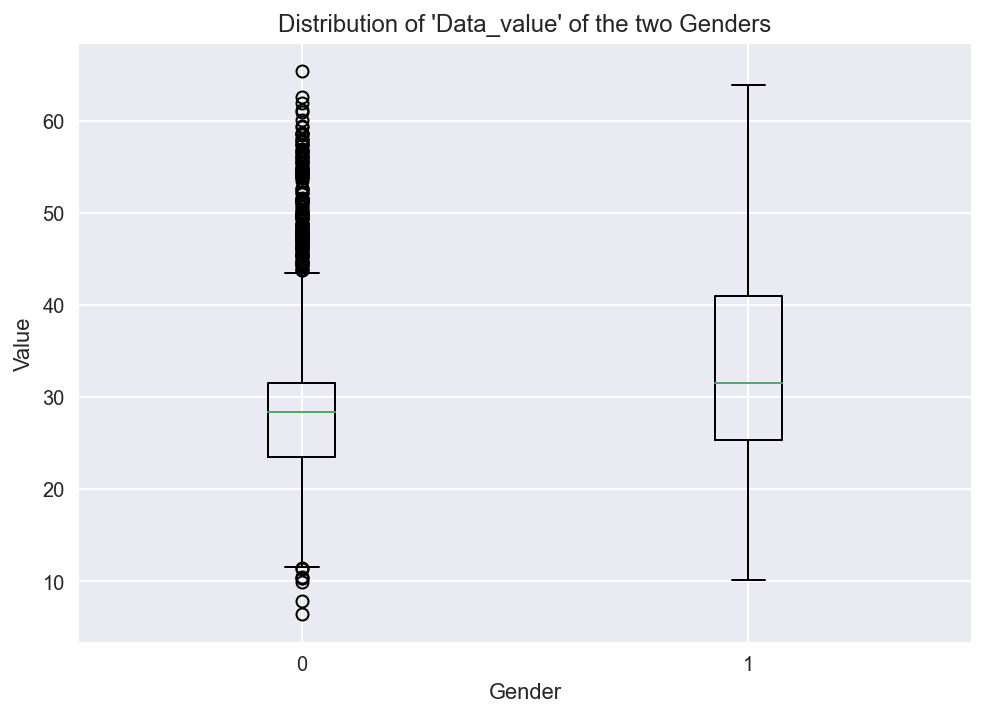

,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Gender
1,32.3,29.9,34.7,2581.0,1
2,31.8,30.0,33.6,4723.0,0
29,39.0,36.5,41.6,2581.0,1
30,30.5,28.7,32.4,4723.0,0
63,40.1,38.2,42.1,4792.0,0
77,47.9,45.2,50.6,2439.0,1
85,26.6,24.2,29.0,2422.0,1
86,22.3,20.6,24.1,4713.0,0
114,45.4,42.7,48.1,2441.0,1
115,39.6,37.6,41.6,4750.0,0


In [3]:
data['Gender'] = data['Gender'].str.replace(r'Male', '1', regex=True)
data['Gender'] = data['Gender'].str.replace(r'Female', '0', regex=True)
data = data[(data['Gender'] == '1') | (data['Gender'] == '0')]
data['Gender'] = data['Gender'].astype(int)
data = data.dropna()

plt.boxplot([data[data['Gender'] == 0]['Data_Value'], data[data['Gender'] == 1]['Data_Value']], positions=[0,1])
plt.xlabel('Gender')
plt.ylabel('Value')
plt.title('Distribution of \'Data_value\' of the two Genders')
plt.show()

data.head(10)

Standardize data by shifting by mean and scaling by variance. Then do a 0.7-0.3 train/test split.

In [4]:
X_pretrain = pd.DataFrame(data.loc[ : , data.columns != 'Gender'] )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_pretrain)
Y_train = data['Gender'].to_numpy()

data = pd.DataFrame({'Data_Value':X_train[:,0],'Low_Confidence_Limit':X_train[:,1], \
                     'High_Confidence_Limit':X_train[:,2], 'Sample_Size':X_train[:,3], 'Gender':Y_train})
data_train, data_test = train_test_split(data, test_size=0.3)
print("train size :", len(data_train), "test size :", len(data_test))
data_train.head(10)

train size : 2669 test size : 1145


,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Gender
2020,-1.576675,-1.535552,-1.615529,-0.086106,0
1025,0.413137,0.465543,0.363893,-0.019440,1
424,-0.153908,-0.282234,-0.009773,-0.222237,1
1676,-0.391036,-0.355959,-0.423836,-0.112847,0
1279,1.371958,1.413431,1.333406,-0.151693,1
198,-0.751882,-0.692986,-0.817701,-0.018563,0
3260,-0.050809,-0.029464,-0.080467,-0.165620,0
598,-0.978700,-0.998416,-0.948989,-0.167374,0
830,1.217309,1.213321,1.222316,-0.155639,1
3664,0.114150,0.117985,0.111416,-0.192327,1


## Logistic Regression with 4 Features

Fit a Linear Logistic model using sklearning. And observe the accuarcy and confusion matrix on the test set.

Accuracy (True Pos/Total):  0.6358078602620088


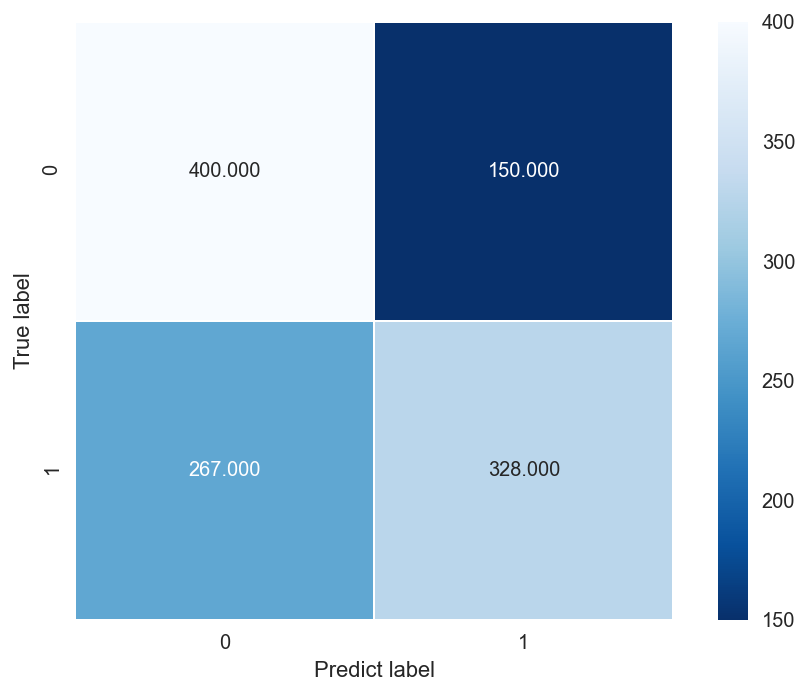

In [5]:
logisticRegr = LogisticRegression(penalty='l2')
X_train = data_train.loc[ : , data.columns != 'Gender'] 
Y_train = data_train['Gender']
X_test = data_test.loc[ : , data.columns != 'Gender'] 
Y_test = data_test['Gender']

logisticRegr.fit(X_train, Y_train)
Y_predict = logisticRegr.predict(X_test)
print('Accuracy (True Pos/Total): ', logisticRegr.score(X_test, Y_test))
sns.heatmap(confusion_matrix(Y_test, Y_predict), annot=True, fmt=".3f", \
            square = True, cmap = 'Blues_r', linewidths=.5);
plt.ylabel('True label');
plt.xlabel('Predict label');
plt.show()

Fit the same linear model with "statsmodels". First using PCA to compress the features into principle components (PCs), and observe the variance preserved and the different classes distribution on the principle component axes. Do the same logistic regression to observe the accuarcy and confusion matrix.

PCA variance ratios:  [0.74780976 0.25030526 0.00188214]
PCA variance explained:  0.9999971620140892


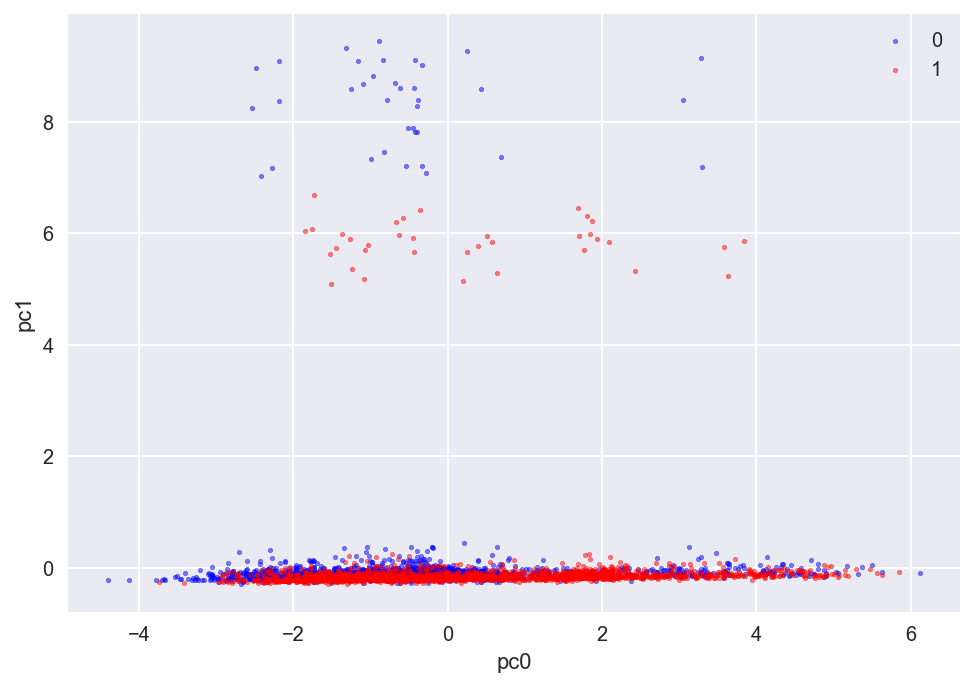

train size : 2669 test size : 1145


,pc0,pc1,pc2,Gender
234,-1.870757,-0.110801,-0.075449,0
2883,-2.085219,-0.199975,-0.002322,0
324,-0.811232,-0.178309,-0.016179,1
448,4.451013,-0.066575,-0.066223,1
3516,2.034395,-0.145002,-0.034870,1
1418,-0.806558,-0.225671,0.091305,1
625,-0.193003,-0.180949,0.038688,0
2811,4.899425,-0.153801,0.228982,0
2902,-2.770436,-0.154018,-0.003234,0
2132,-0.384423,0.005430,-0.045447,0


In [6]:
n_components = 3

pc_columns = []
colors = ['b','r']
for i in range(n_components):
    pc_columns.append('pc%i'%i)
    
#pca = PCA(0.95)
pca = PCA(n_components=n_components)
PCs = pca.fit_transform(data.loc[ : , data.columns != 'Gender'] )
pc_data = pd.DataFrame(data = PCs, columns = pc_columns)
pc_data['Gender'] = data['Gender']

pca_var = pca.explained_variance_ratio_
print('PCA variance ratios: ', pca_var)
print('PCA variance explained: ', sum(pca_var))

for i in (0,1):
    plt.scatter(pc_data[pc_data['Gender'] == i][pc_columns[0]], pc_data[pc_data['Gender'] == i][pc_columns[1]], \
                label=i, alpha=0.5, s=scatter_pt_size, color=colors[i])
plt.xlabel(pc_columns[0])
plt.ylabel(pc_columns[1])
plt.legend()
plt.show()

data_train, data_test = train_test_split(pc_data, test_size=0.3)
print("train size :", len(data_train), "test size :", len(data_test))
data_train.head(10)

In [7]:
X_train = data_train.loc[ : , pc_data.columns != 'Gender'] 
Y_train = data_train['Gender']
X_test = data_test.loc[ : , pc_data.columns != 'Gender'] 
Y_test = data_test['Gender']

logit = sm.Logit(Y_train, X_train)
logit_reg = logit.fit()
print(logit_reg.params,'\n')
print(logit_reg.summary())

Optimization terminated successfully.
         Current function value: 0.637727
         Iterations 5
pc0    0.299552
pc1   -0.088532
pc2    6.018131
dtype: float64 

                           Logit Regression Results                           
Dep. Variable:                 Gender   No. Observations:                 2669
Model:                          Logit   Df Residuals:                     2666
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Feb 2021   Pseudo R-squ.:                 0.07995
Time:                        14:26:54   Log-Likelihood:                -1702.1
converged:                       True   LL-Null:                       -1850.0
Covariance Type:            nonrobust   LLR p-value:                 5.810e-65
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pc0            0.2996      0.025     12.096

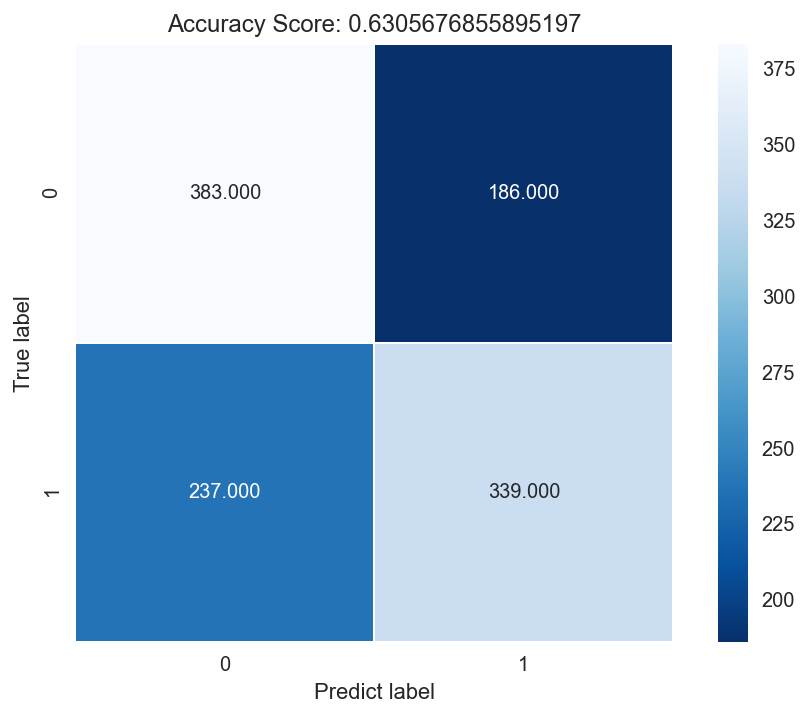

In [8]:
Y_prob = logit_reg.predict(X_test) 
Y_pred = list(map(round, Y_prob)) 
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt=".3f", \
            square = True, cmap = 'Blues_r', linewidths=.5);
plt.title(r'Accuracy Score: %s' % accuracy_score(Y_test, Y_pred))
plt.ylabel('True label');
plt.xlabel('Predict label');
plt.show()